In [160]:
import pandas as pd
import pyodbc
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [161]:
print(pyodbc.drivers())

['SQL Server', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server']


In [162]:
engine = create_engine(
    "mssql+pyodbc://@localhost/Chinook?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

# Creating our DF

In [163]:
query = """
SELECT 
    c.CustomerId,
    c.FirstName + ' ' + c.LastName AS CustomerName,
    c.Country,
    c.Email,
    i.Total AS Sales,
    i.InvoiceDate,
    i.BillingCity,
    i.BillingState
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId;
"""
df = pd.read_sql_query(query, engine)


In [164]:
df.head()

,CustomerId,CustomerName,Country,Email,Sales,InvoiceDate,BillingCity,BillingState
0,1,Luís Gonçalves,Brazil,luisg@embraer.com.br,3.98,2022-03-11,São José dos Campos,SP
1,1,Luís Gonçalves,Brazil,luisg@embraer.com.br,3.96,2022-06-13,São José dos Campos,SP
2,1,Luís Gonçalves,Brazil,luisg@embraer.com.br,5.94,2022-09-15,São José dos Campos,SP
3,1,Luís Gonçalves,Brazil,luisg@embraer.com.br,0.99,2023-05-06,São José dos Campos,SP
4,1,Luís Gonçalves,Brazil,luisg@embraer.com.br,1.98,2024-10-27,São José dos Campos,SP


In [165]:
df.isnull().sum()

CustomerId        0
CustomerName      0
Country           0
Email             0
Sales             0
InvoiceDate       0
BillingCity       0
BillingState    202
dtype: int64

In [ ]:
df['BillingState'].fillna('Unknown', inplace=True)

In [167]:
df.duplicated().sum()

np.int64(0)

In [168]:
sales =df['Sales']
sales.describe()

count    412.000000
mean       5.651942
std        4.745320
min        0.990000
25%        1.980000
50%        3.960000
75%        8.910000
max       25.860000
Name: Sales, dtype: float64

# Changing dtype of Invoice date column

In [169]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Text(0.5, 1.0, 'Number of Customers by Country')

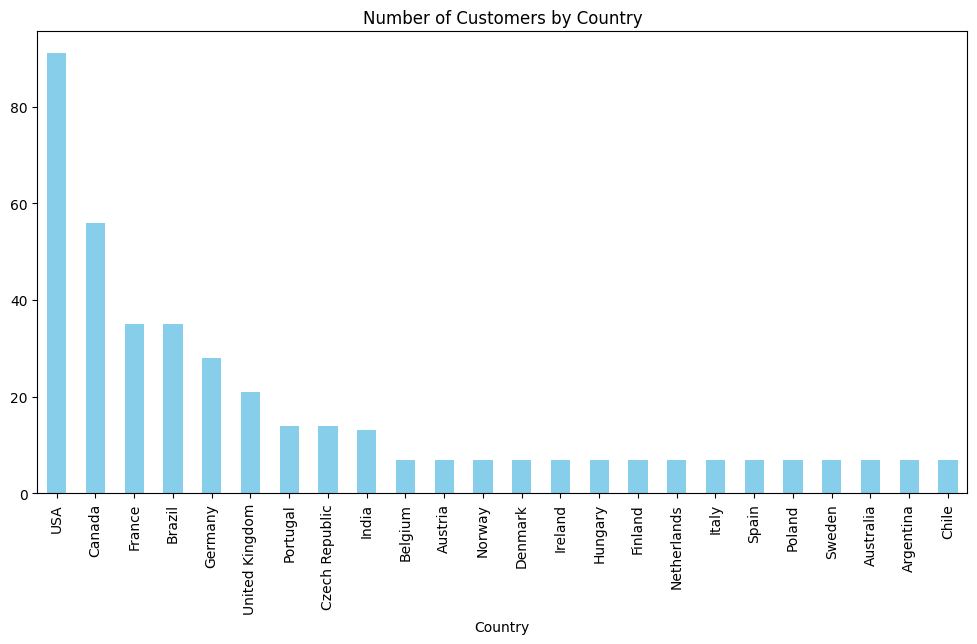

In [170]:
df['Country'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Number of Customers by Country')

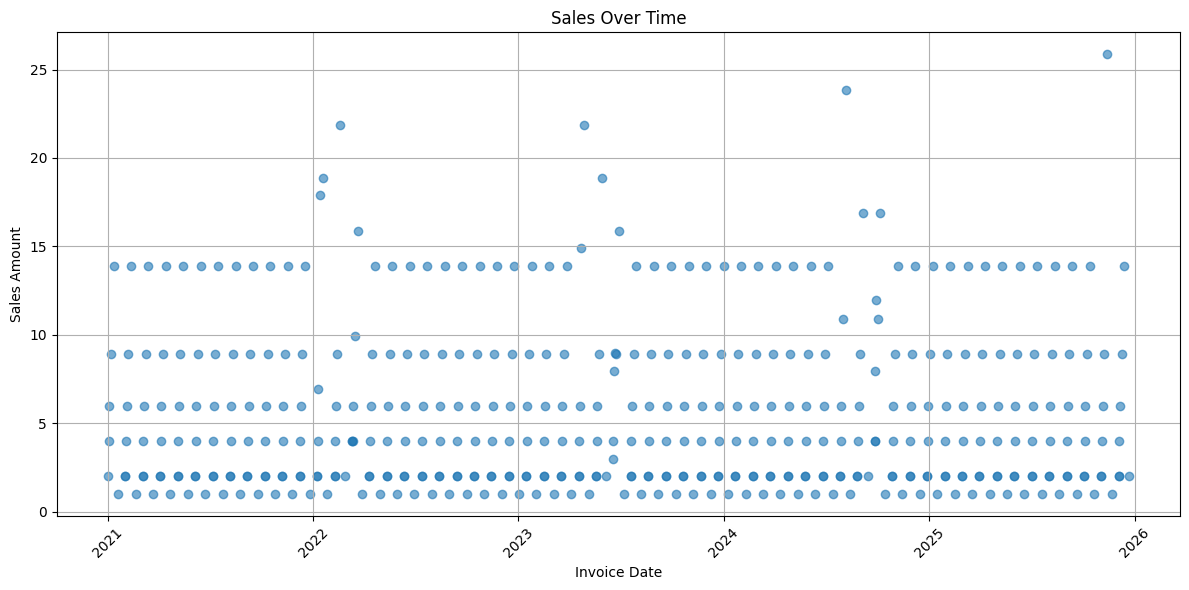

In [171]:
plt.figure(figsize=(12, 6))
plt.scatter(df['InvoiceDate'], df['Sales'], alpha=0.6)
plt.title('Sales Over Time')
plt.xlabel('Invoice Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
top_customers = df.groupby('CustomerName')['Sales'].sum().sort_values(ascending=False).head(10)

print(top_customers)


CustomerName
Helena Holý           49.62
Richard Cunningham    47.62
Luis Rojas            46.62
Hugh O'Reilly         45.62
Ladislav Kovács       45.62
Fynn Zimmermann       43.62
Frank Ralston         43.62
Julia Barnett         43.62
Astrid Gruber         42.62
Victor Stevens        42.62
Name: Sales, dtype: float64


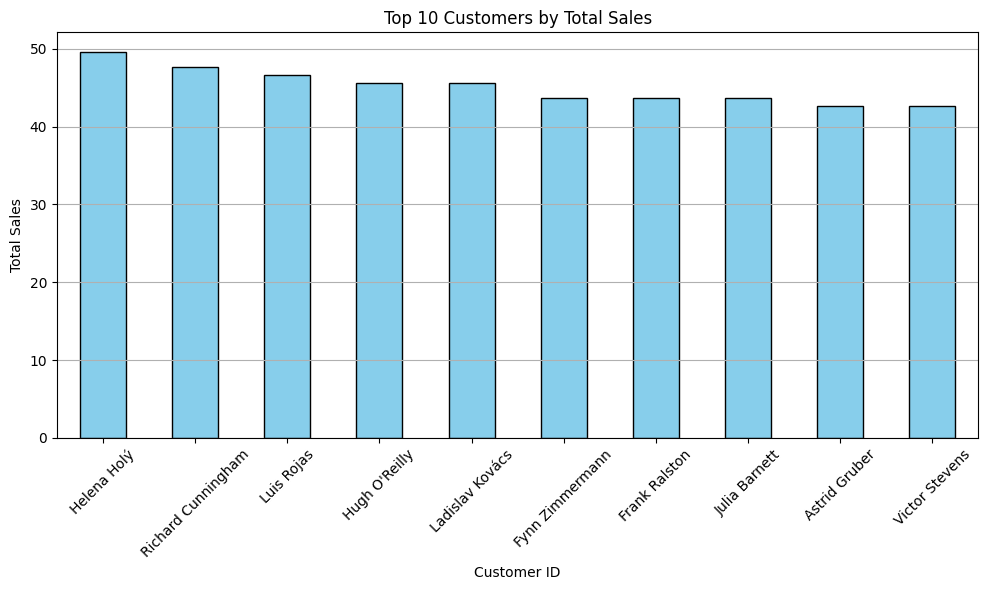

In [173]:
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers by Total Sales')
plt.xlabel('Customer ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

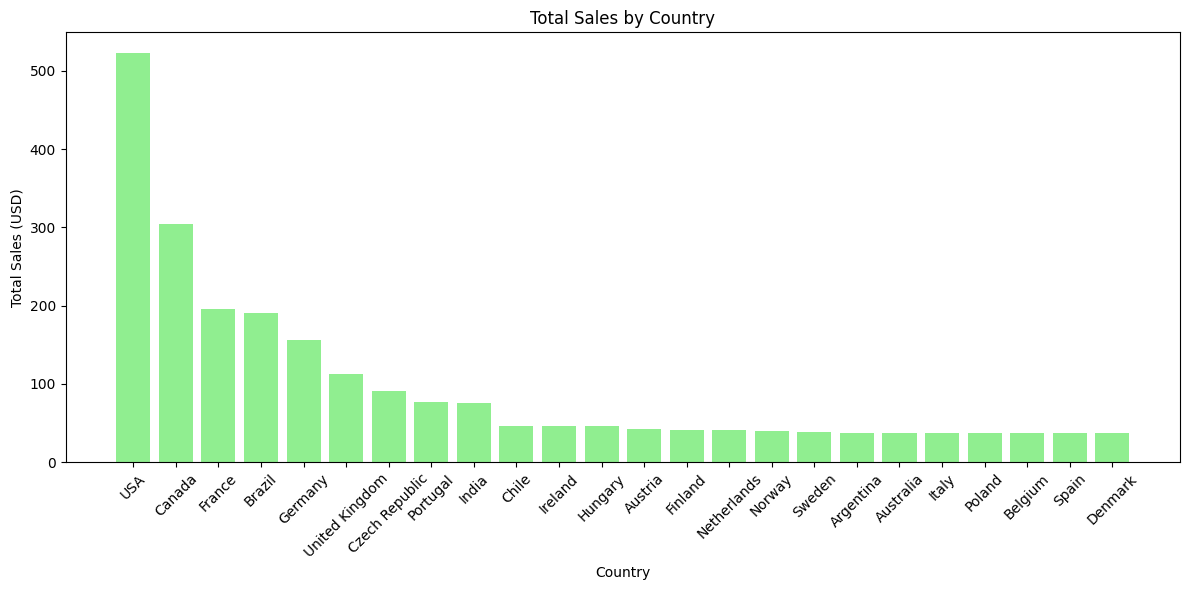

In [174]:


query = """
SELECT c.Country, SUM(il.UnitPrice * il.Quantity) AS TotalSales
FROM InvoiceLine il
JOIN Invoice i ON i.InvoiceId = il.InvoiceId
JOIN Customer c ON c.CustomerId = i.CustomerId
GROUP BY c.Country
ORDER BY TotalSales DESC
"""
df = pd.read_sql(query, engine)


plt.figure(figsize=(12,6))
plt.bar(df['Country'], df['TotalSales'], color='lightgreen')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


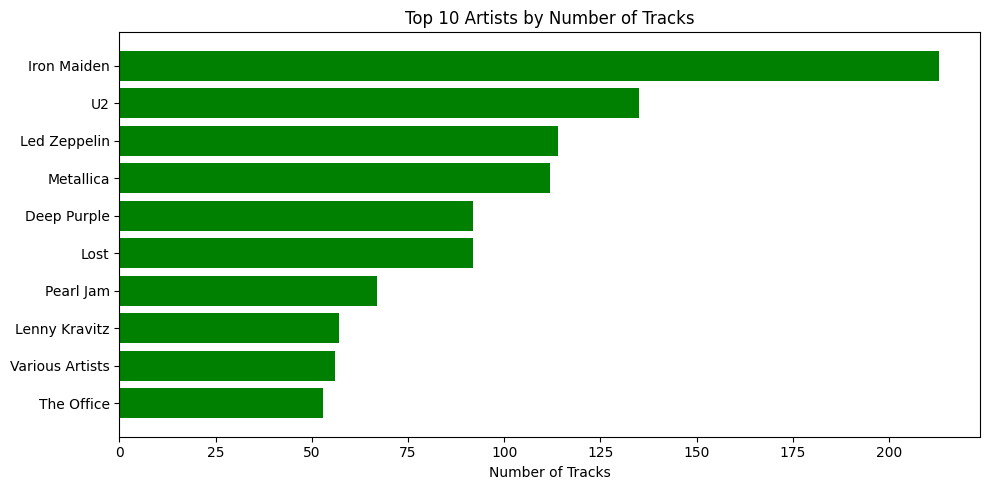

In [175]:
query = """
SELECT TOP 10 a.Name AS Artist, COUNT(t.TrackId) AS NumberOfTracks
FROM Artist a
JOIN Album al ON a.ArtistId = al.ArtistId
JOIN Track t ON al.AlbumId = t.AlbumId
GROUP BY a.Name
ORDER BY NumberOfTracks DESC
"""
df = pd.read_sql_query(query, engine)

plt.figure(figsize=(10,5))
plt.barh(df['Artist'], df['NumberOfTracks'], color='green')
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


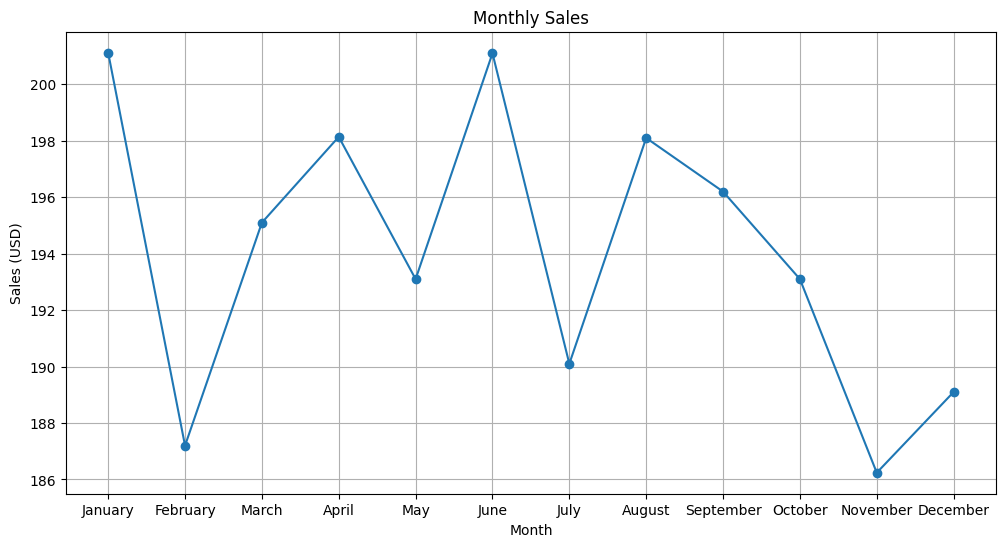

In [176]:
query = """
SELECT DATENAME(MONTH, InvoiceDate) AS MonthName,
       MONTH(InvoiceDate) AS MonthNum,
       SUM(Total) AS MonthlySales
FROM Invoice
GROUP BY DATENAME(MONTH, InvoiceDate), MONTH(InvoiceDate)
ORDER BY MonthNum
"""
df = pd.read_sql_query(query, engine)

plt.figure(figsize=(12, 6))
plt.plot(df['MonthName'], df['MonthlySales'], marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.show()


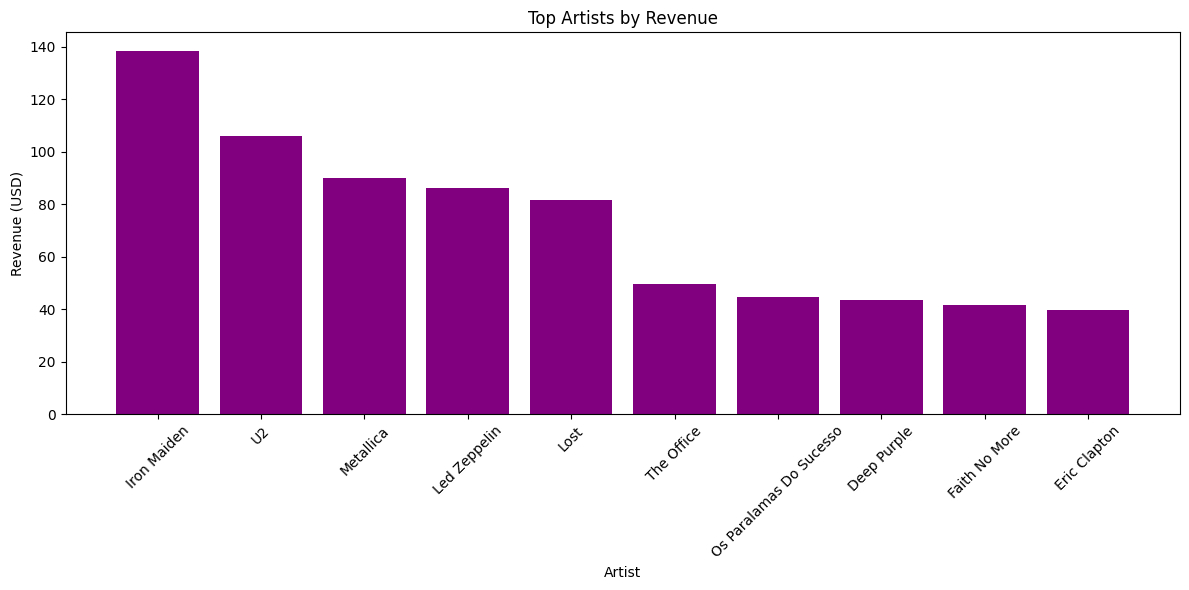

In [178]:
query= """SELECT top 10 a.Name AS Artist, SUM(il.UnitPrice * il.Quantity) AS Revenue
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
JOIN Album al ON t.AlbumId = al.AlbumId
JOIN Artist a ON al.ArtistId = a.ArtistId
GROUP BY a.Name
ORDER BY Revenue DESC
"""
df = pd.read_sql_query(query, engine)
plt.figure(figsize=(12, 6))
plt.bar(df['Artist'], df['Revenue'], color='purple')
plt.title('Top Artists by Revenue')
plt.xlabel('Artist')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

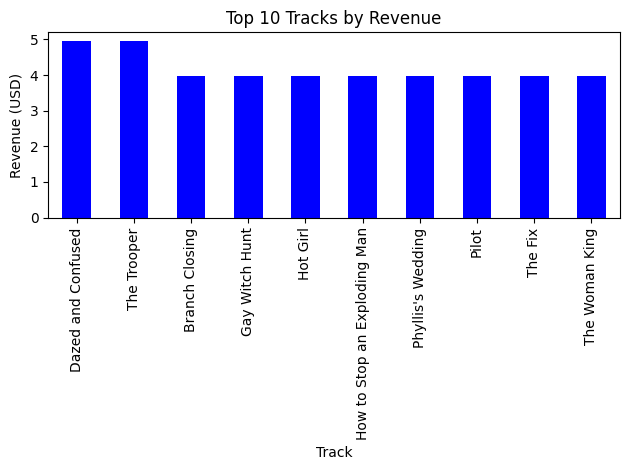

In [182]:
query ="""SELECT TOP 10 
    t.Name AS Track, 
    SUM(il.UnitPrice * il.Quantity) AS Revenue
FROM InvoiceLine il
JOIN Track t ON il.TrackId = t.TrackId
GROUP BY t.Name
ORDER BY Revenue DESC;
"""
df = pd.read_sql_query(query, engine)
plt.figure(figsize=(12, 6))
df.plot(kind='bar', x='Track', y='Revenue', color='blue', legend=False)
plt.title('Top 10 Tracks by Revenue')
plt.xlabel('Track')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
